# Cross-sell Health Insurance Project

Feature|Description
--|--------------------------|
id|	Unique ID for the customer
Gender|	Gender of the customer
Age|	Age of the customer
Driving_License|	0 : Customer does not have DL, 1 : Customer already has DL
Region_Code|	Unique code for the region of the customer
Previously_Insured|	1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance
Vehicle_Age|	Age of the Vehicle
Vehicle_Damage|	1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.
Annual_Premium|	The amount customer needs to pay as premium in the year
PolicySalesChannel|	Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
Vintage|	Number of Days, Customer has been associated with the company
Response|	1 : Customer is interested, 0 : Customer is not interested

## Insurance Business Model

An insurance business works like this: the insurance company assumes the risks of individual payers and redistributes it across a larger group of people.
There are, generally, two ways of generating revenues: charging premiums for insurance coverage and then reinvesting those premiums into interest-generating assets.
The premium is based on the risk of each customer. The company has to estimate the probability of a customer claiming the insurance and extend this risk till the end of the contract. The customers with the highest risks pay more, and the ones with the lowest risks pay less.

## Cross Selling Strategy

Cross-selling is a strategy for selling complementary products or related and complementary services, taking into account the customer's interest. In our case, we have a health insurance company that wants to sell vehicle insurance to its customers.

**Benefits**

Acquiring new customers is too expensive. So if we can sell other products to people that are already customers, we will spend less money to achieve the revenue goal.

# 0.0 Imports

In [3]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from matplotlib.gridspec import GridSpec
from IPython.core.display import HTML
from IPython.display import Image
import os
import statsmodels.stats.proportion as sp
import scipy.stats as ss
import helper_function as hf
import pickle

import scikitplot as skplt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_validate, cross_val_score
from boruta import BorutaPy
from sklearn.pipeline import Pipeline


# Encoders
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, RobustScaler
import category_encoders as ce
from feature_engine import encoding as enc

# Models
from sklearn.linear_model import LogisticRegressionCV
import xgboost
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB

# Evaluation
from sklearn import metrics as met
from sklearn.compose import ColumnTransformer
from imblearn import under_sampling as und_samp
from imblearn.pipeline import Pipeline as imbpipeline

# Fine Tuning
import optuna
from optuna.samplers import TPESampler
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances

In [2]:
sns.set_style(style='darkgrid')
plt.rcParams['figure.figsize'] = [25, 12]
plt.rcParams['font.size'] = 12
display('<style.container {width: 100% !important; }</style')
plt.rcParams['figure.autolayout'] = True

pd.options.display.max_columns = None

'<style.container {width: 100% !important; }</style'

## 1.0 Loading Data

In [3]:
train_data = pd.read_csv('../data/train.csv')
train_data.head()

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,response,driving_license,vehicle_age,vehicle_damage
0,265884,Female,27,15.0,152.0,0,26898.0,106,0,1,< 1 Year,No
1,246327,Female,45,33.0,120.0,0,34133.0,238,0,1,1-2 Year,Yes
2,179485,Male,66,50.0,8.0,0,48486.0,173,0,1,> 2 Years,Yes
3,74613,Female,25,25.0,160.0,1,30780.0,228,0,1,< 1 Year,Yes
4,217056,Female,59,37.0,26.0,1,35575.0,238,0,1,1-2 Year,No


In [4]:
test = pd.read_csv('../data/test_eval.csv')

# 2.0 Descriptive Analysis & Data Cleaning

In [5]:
df1 = train_data.copy()

## 2.1 Data Dimension

In [6]:
print('Number of Columns:', df1.shape[1])
print('Number of Rows:', df1.shape[0])

Number of Columns: 12
Number of Rows: 323942


## 2.2 Data Types

In [7]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
driving_license           int64
vehicle_age              object
vehicle_damage           object
dtype: object

## 2.3 Missing Values

In [8]:
df1.isnull().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
previously_insured      0
annual_premium          0
vintage                 0
response                0
driving_license         0
vehicle_age             0
vehicle_damage          0
dtype: int64

In [9]:
df1['response'].value_counts()

0    284239
1     39703
Name: response, dtype: int64

**The data is unbalanced**

# 2.4. Descriptive Statisitcs

## 2.4.1. Numerical Variables

In [10]:
num_att = df1.select_dtypes(include=['float64', 'int64'])

In [11]:
num_att.agg(['min', 'max', 'ptp', 'mean', 'median', 'var', 'std', 'skew', 'kurtosis']).T.reset_index().rename(columns={'index': 'Attributes', 'ptp': 'range'})

,Attributes,min,max,range,mean,median,var,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190689.986837,190766.5,1.210790e+10,110035.891657,-0.000509,-1.199872
1,age,20.0,85.0,65.0,38.827691,36.0,2.407040e+02,15.514640,0.671487,-0.568759
2,region_code,0.0,52.0,52.0,26.396827,28.0,1.750852e+02,13.231976,-0.115599,-0.868099
3,policy_sales_channel,1.0,163.0,162.0,112.059356,133.0,2.936235e+03,54.187035,-0.901072,-0.968501
4,previously_insured,0.0,1.0,1.0,0.457897,0.0,2.482281e-01,0.498225,0.169014,-1.971446
5,annual_premium,2630.0,540165.0,537535.0,30579.735274,31687.0,2.964092e+08,17216.538291,1.693696,31.463205
6,vintage,10.0,299.0,289.0,154.396858,154.0,6.998009e+03,83.654103,0.001833,-1.200090
7,response,0.0,1.0,1.0,0.122562,0.0,1.075409e-01,0.327934,2.301926,3.298883
8,driving_license,0.0,1.0,1.0,0.997848,1.0,2.146997e-03,0.046336,-21.488894,459.775412


Annual premium of $ 540,165 doesn't seem reasonable.

## 3.0 New Features

In [12]:
df2 = df1.copy()

In [13]:
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x== '1-2 Year' else 'under_1_year')

df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)


# 4.0 Exploratory Analysis

In [14]:
df3 = df2.copy()

### 4.1.1 Numerical Variables

<Figure size 3000x1500 with 0 Axes>

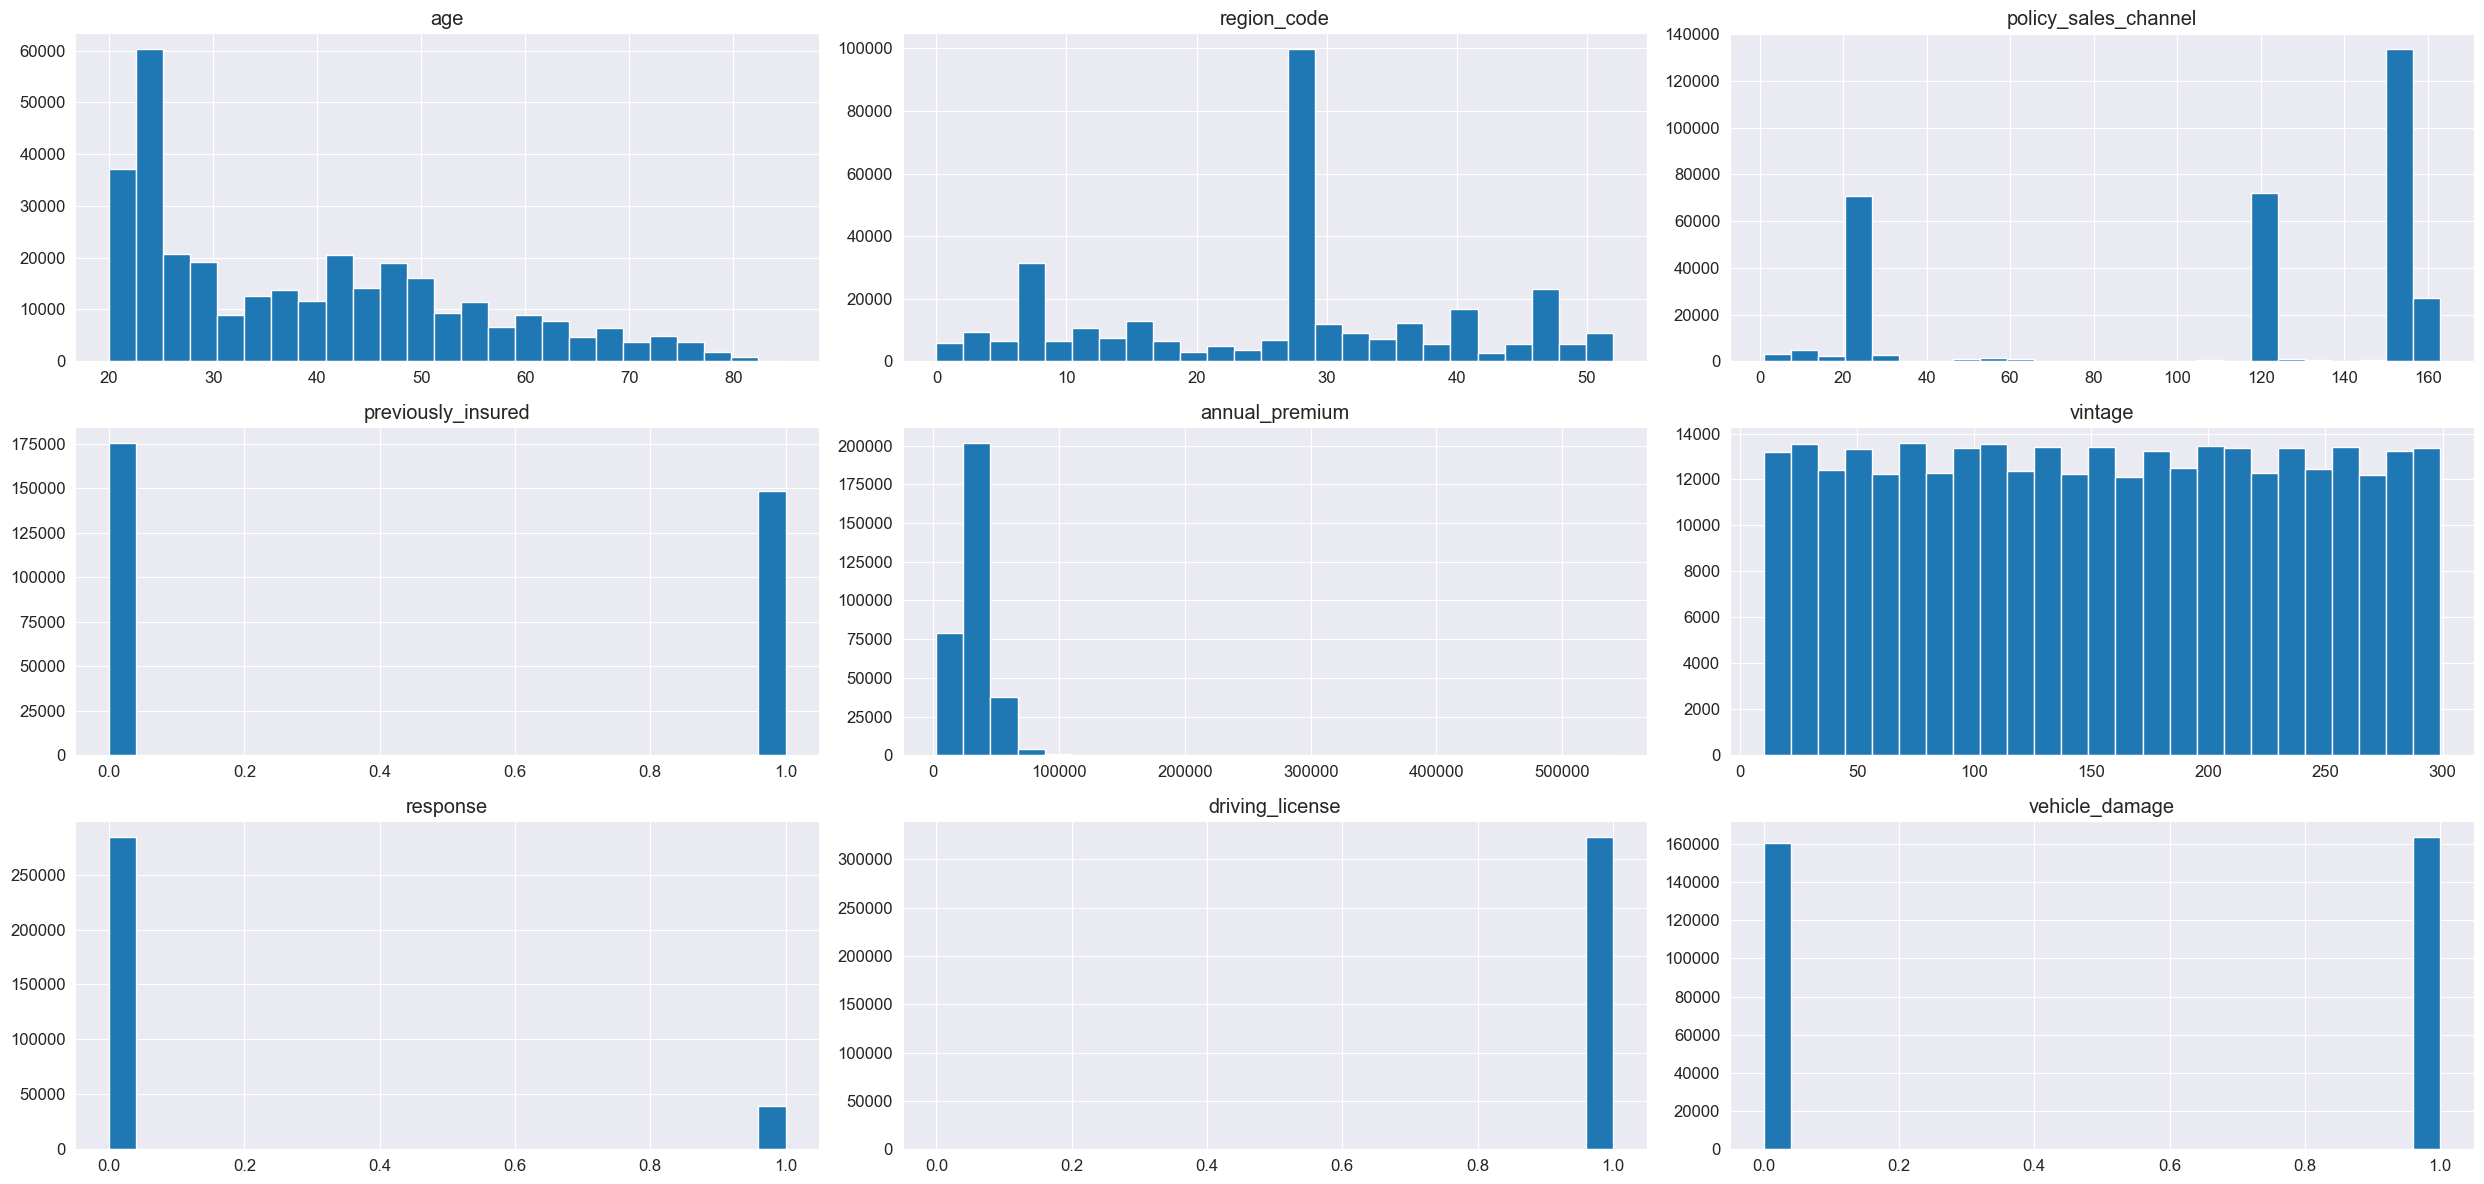

In [15]:
plt.figure(figsize=(30, 15))
df3.select_dtypes(include=['float64', 'int64']).drop('id', axis=1).hist(bins=25);

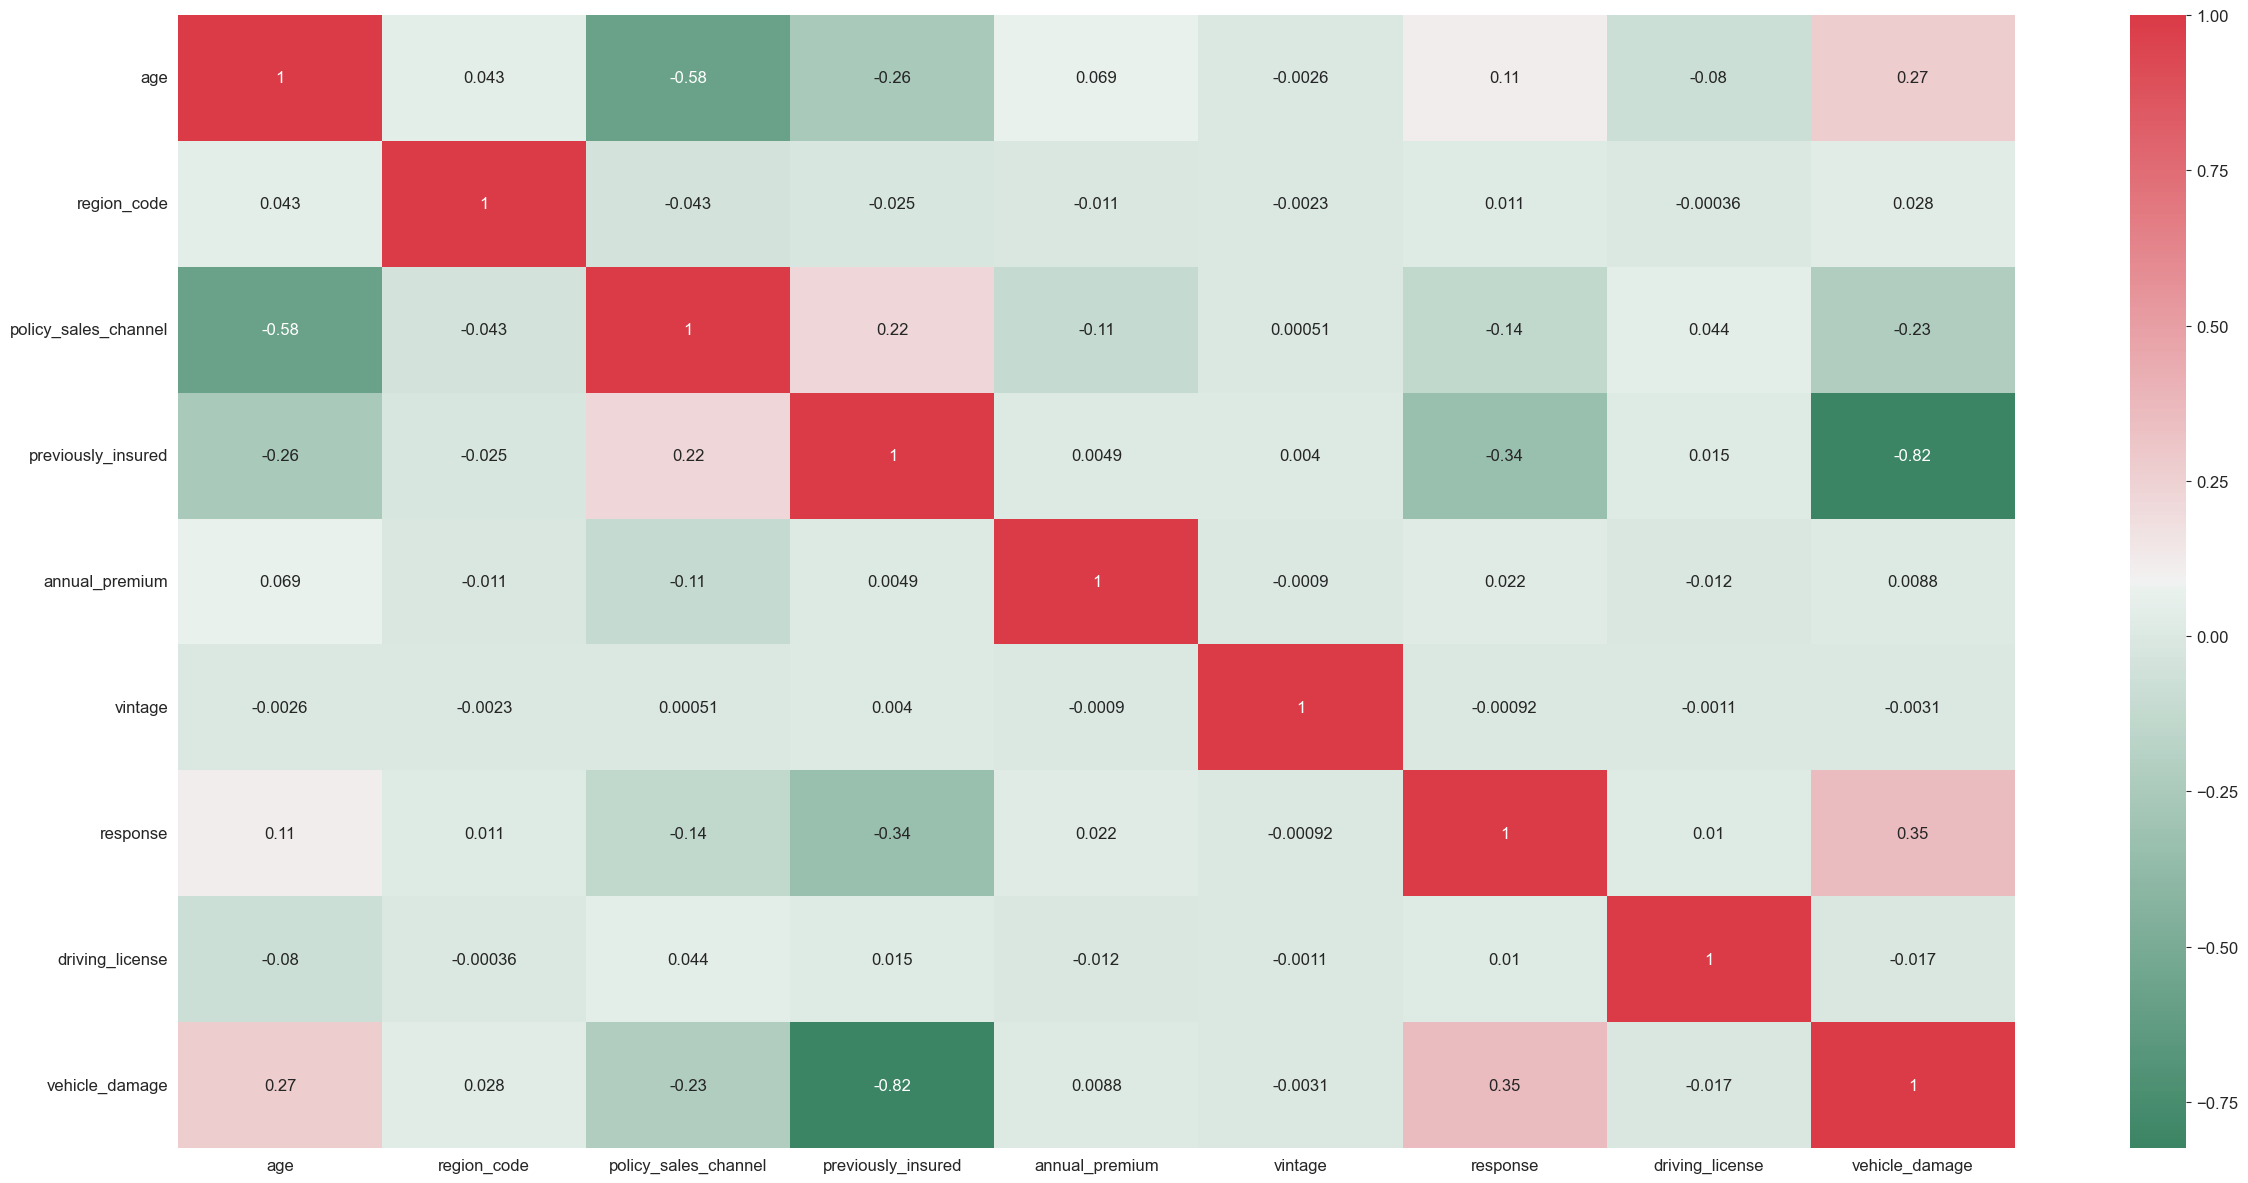

In [16]:
corr = df3.drop('id', axis=1).corr(numeric_only=True)
cmap = sns.diverging_palette(150, 10, as_cmap=True)

sns.heatmap(corr, annot=True, cmap=cmap,);

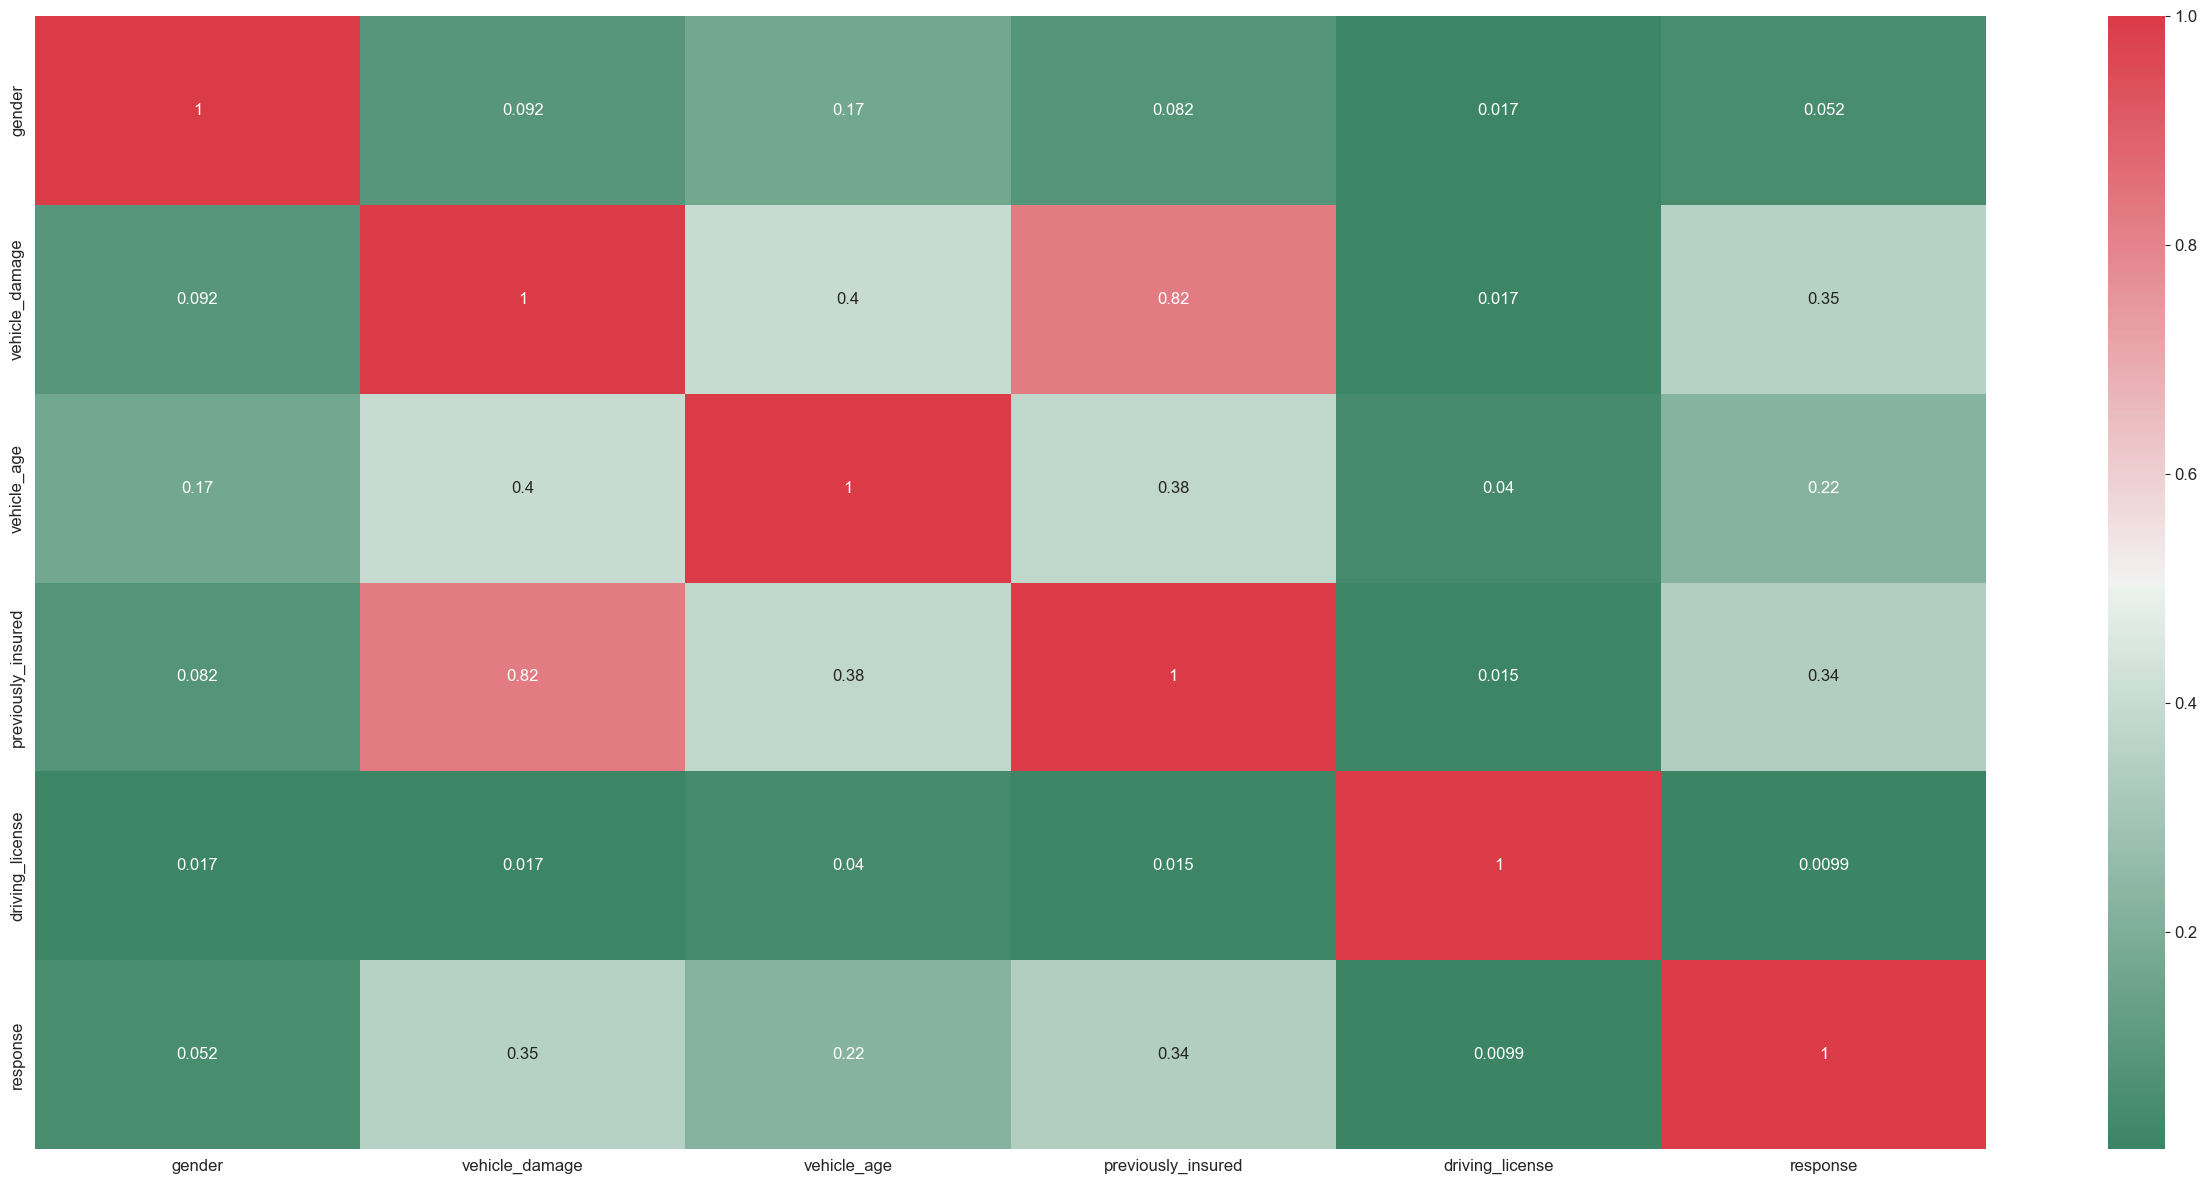

In [17]:
dic = {}
lis = []
for att in ['gender', 'vehicle_damage', 'vehicle_age', 'previously_insured', 'driving_license', 'response']:
    for att_2 in ['gender', 'vehicle_damage', 'vehicle_age', 'previously_insured', 'driving_license', 'response']:
        a = hf.cramer_v(df3[att], df3[att_2])
        lis.append(a)
    lista = lis.copy()
    dic[att] = lista
    lis.clear()
assoc = pd.DataFrame(dic)
assoc = assoc.set_index(assoc.columns)
sns.heatmap(assoc, cmap=cmap, annot=True);


# 5.0. Data Preparation

In [18]:
df4 = df3.copy()

In [19]:
df_train, df_val = train_test_split(df4, test_size=0.17647, stratify=df4['response'], random_state=42)

**Train, Validation and Test**

In [20]:
# Cross-validation data
X_train_cv = df4.drop(['id', 'response'], axis=1)
y_train_cv = df4['response'].copy()

# Train data
X_train = df_train.drop(['id', 'response'], axis=1)
y_train = df_train['response'].copy()

# Validation set
X_val = df_val.drop(['id', 'response'], axis=1)
y_val = df_val['response'].copy()

# Unseen data (test)
X_test = test.drop(['id', 'response'], axis=1)
y_test = test['response'].copy()

In [21]:
# Applying the same transformations to the  tes set.
X_test['vehicle_age'] = X_test['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x== '1-2 Year' else 'under_1_year')

X_test['vehicle_damage'] = X_test['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

## 5.1. Resampling

In [22]:
# Random Undersampling for KNN and ExtraTrees
undersampling = und_samp.RandomUnderSampler(sampling_strategy='majority', random_state=42)

X_under, y_under = undersampling.fit_resample(X_train, y_train)

## 5.1 Pipeline for data preparation and model training.

Robust Scaler -> Numerical features with outliers that doesn't have a normal distribution.

 - Annual Premium

MinMaxScaler -> Features that doesn't have outliers and doesn't follow a normal distribution.

 - Age

Frequency Encoder

 - Region Code
 - Policy Sales Channel
 - vehicle_age

OneHot Encoder

- gender
- vehicle_damage
- vehicle_age

In [23]:
pass_cols = ['previously_insured', 'driving_license']

# OneHot Encoding
onehot = OneHotEncoder()
oneh_cols = ['gender', 'vehicle_damage', 'vehicle_age']
oh_transformmer = Pipeline([('onehot_enc', onehot)])

# Robust Scaler
robust_sc = RobustScaler()
robust_cols = ['annual_premium']
rob_transformer = Pipeline([('robust_sc', robust_sc)])

# MinMax Scaler
minmax_sc = MinMaxScaler()
minmax_cols = ['age', 'vintage']
minmax_transformer = Pipeline([('minmax_sc', minmax_sc)])

# Frequency Encoder
freq_enc = enc.CountFrequencyEncoder(encoding_method='frequency', ignore_format=True, unseen='encode')
freq_cols = ['region_code', 'policy_sales_channel']
freq_transformer = Pipeline([('frequency_enc', freq_enc)])

preprocess_scaling = ColumnTransformer(transformers=[('onehot', oh_transformmer, oneh_cols),
                                ('robust_scaler', rob_transformer, robust_cols),
                                ('minmax', minmax_transformer, minmax_cols),
                                ('freq_enconder', freq_transformer, freq_cols),
                                ('pass', 'passthrough', pass_cols)
                                ])


# 6.0 Feature Selection

In this section, I will use a python library called Boruta, to find the most important features and then see if we improve our results.

## 6.1 Boruta for Feature Selection

In [24]:
#X_boruta_train = preprocess_scaling.fit_transform(X_train)
#X_boruta_val = preprocess_scaling.transform(X_val)
##
#new_cols = preprocess_scaling.named_transformers_['onehot'].named_steps['onehot_enc'].#get_feature_names_out(oneh_cols)
#
#columns = np.concatenate([new_cols, robust_cols, minmax_cols, freq_cols, pass_cols])
#
#X_boruta_train = pd.DataFrame(X_boruta_train, columns=columns)
#X_boruta_val = pd.DataFrame(X_boruta_val, columns=columns)

In [25]:
#xgb = xgboost.XGBClassifier(n_jobs=-1, random_state=42)

#boruta_xgb = BorutaPy(xgb, n_estimators='auto', verbose=2, random_state=42).fit(X_boruta_train.values, y_train.ravel())

In [26]:
#cols_xgb = X_boruta_train.iloc[:, boruta_xgb.support_.tolist()].columns

Selected Columns

['gender_Female', 'vehicle_damage_0', 'vehicle_age_between_1_2_year',
       'vehicle_age_over_2_years', 'vehicle_age_under_1_year',
       'annual_premium', 'age', 'region_code', 'policy_sales_channel',
       'previously_insured', 'driving_license']

Columns to remove

['gender_Male', 'vehicle_damage_1', 'vintage']

# 7.0 Machine Learning Models

**Metrics**

For this problem, I am interested in ordering the dataset by the propensity score of acquiring vehicle insurance, so the usual classification metrics are not ideal here. So, the ranking metrics — lift, precision_at_k, recall_at_k — will be more relevant to compare the models.
I will also use the cumulative gain curve, lift curve, and roc_auc to assess the model's performance.

- Precision_at_k: this metric tells us, in a list ordered by the score given by the model, the percentage of interested customers in the first k elements of the list.

- Recall_at_k: this metric tells us, of all interested customers, what percentage is in the first k elements of a list sorted by the score given by the model.

- Lift Score: measure how much better or model is compared to a random model. In our case, it tells us that we can expect to catch N times more interested customers using the model then we would by targeting the same number of customers randomly.

- ROC AUC: this metric can be interpreted as the probability that the model ranks a random positive element more highly than a random negative element.

- Cumulative Gain Curve: This curve shows the percentange of targets reached in a certain percentage of the population ordered by the score given by the model.

- Lift Curve: this curve shows us the lift score for different points on the x-coordinate. It shows the lift score if you take into account X% of the sorted data - the elements are sorted in descending order by the propensity score.


In the previous cycle, I tested different methods of dealing with data imbalance. Undersampling had the best results for KNN and ExtraTrees. For LogisticRegression and LightGBM, better results were obtained using the class_weight parameter. And for GaussianNB, the results were better without resampling.


Now, I will compare the metrics of the models using, for each model, the method to deal with data imbalance with the best results from the previous cycle.

In [27]:
# Defined a new 'ColumnsTransformer' to remove the columns that weren't selected with boruta.

# setting drop to remove the first column of the onehot encoder.
onehot = OneHotEncoder(drop='if_binary')
oneh_cols = ['gender', 'vehicle_damage', 'vehicle_age']
oh_transformmer = Pipeline([('onehot_enc', onehot)])

minmax_cols = ['age']
robust_cols = ['annual_premium']
freq_cols = ['region_code', 'policy_sales_channel']


preprocess_scaling = ColumnTransformer(transformers=[('onehot', oh_transformmer, oneh_cols),
                                ('robust_scaler', rob_transformer, robust_cols),
                                ('minmax', minmax_transformer, minmax_cols),
                                ('freq_enconder', freq_transformer, freq_cols),
                                ('pass', 'passthrough', pass_cols)
                                ])

## 7.1 Logistic Regression

In [28]:
import warnings
warnings.filterwarnings('ignore')

In [29]:
lr_clf = LogisticRegressionCV(random_state=42, class_weight='balanced')

pipe = Pipeline(steps=[('preprocess', preprocess_scaling), ('LogisticClassifier', lr_clf)])
pipe.fit(X_train, y_train)
y_hat = pipe.predict(X_val)
y_prob = pipe.predict_proba(X_val)

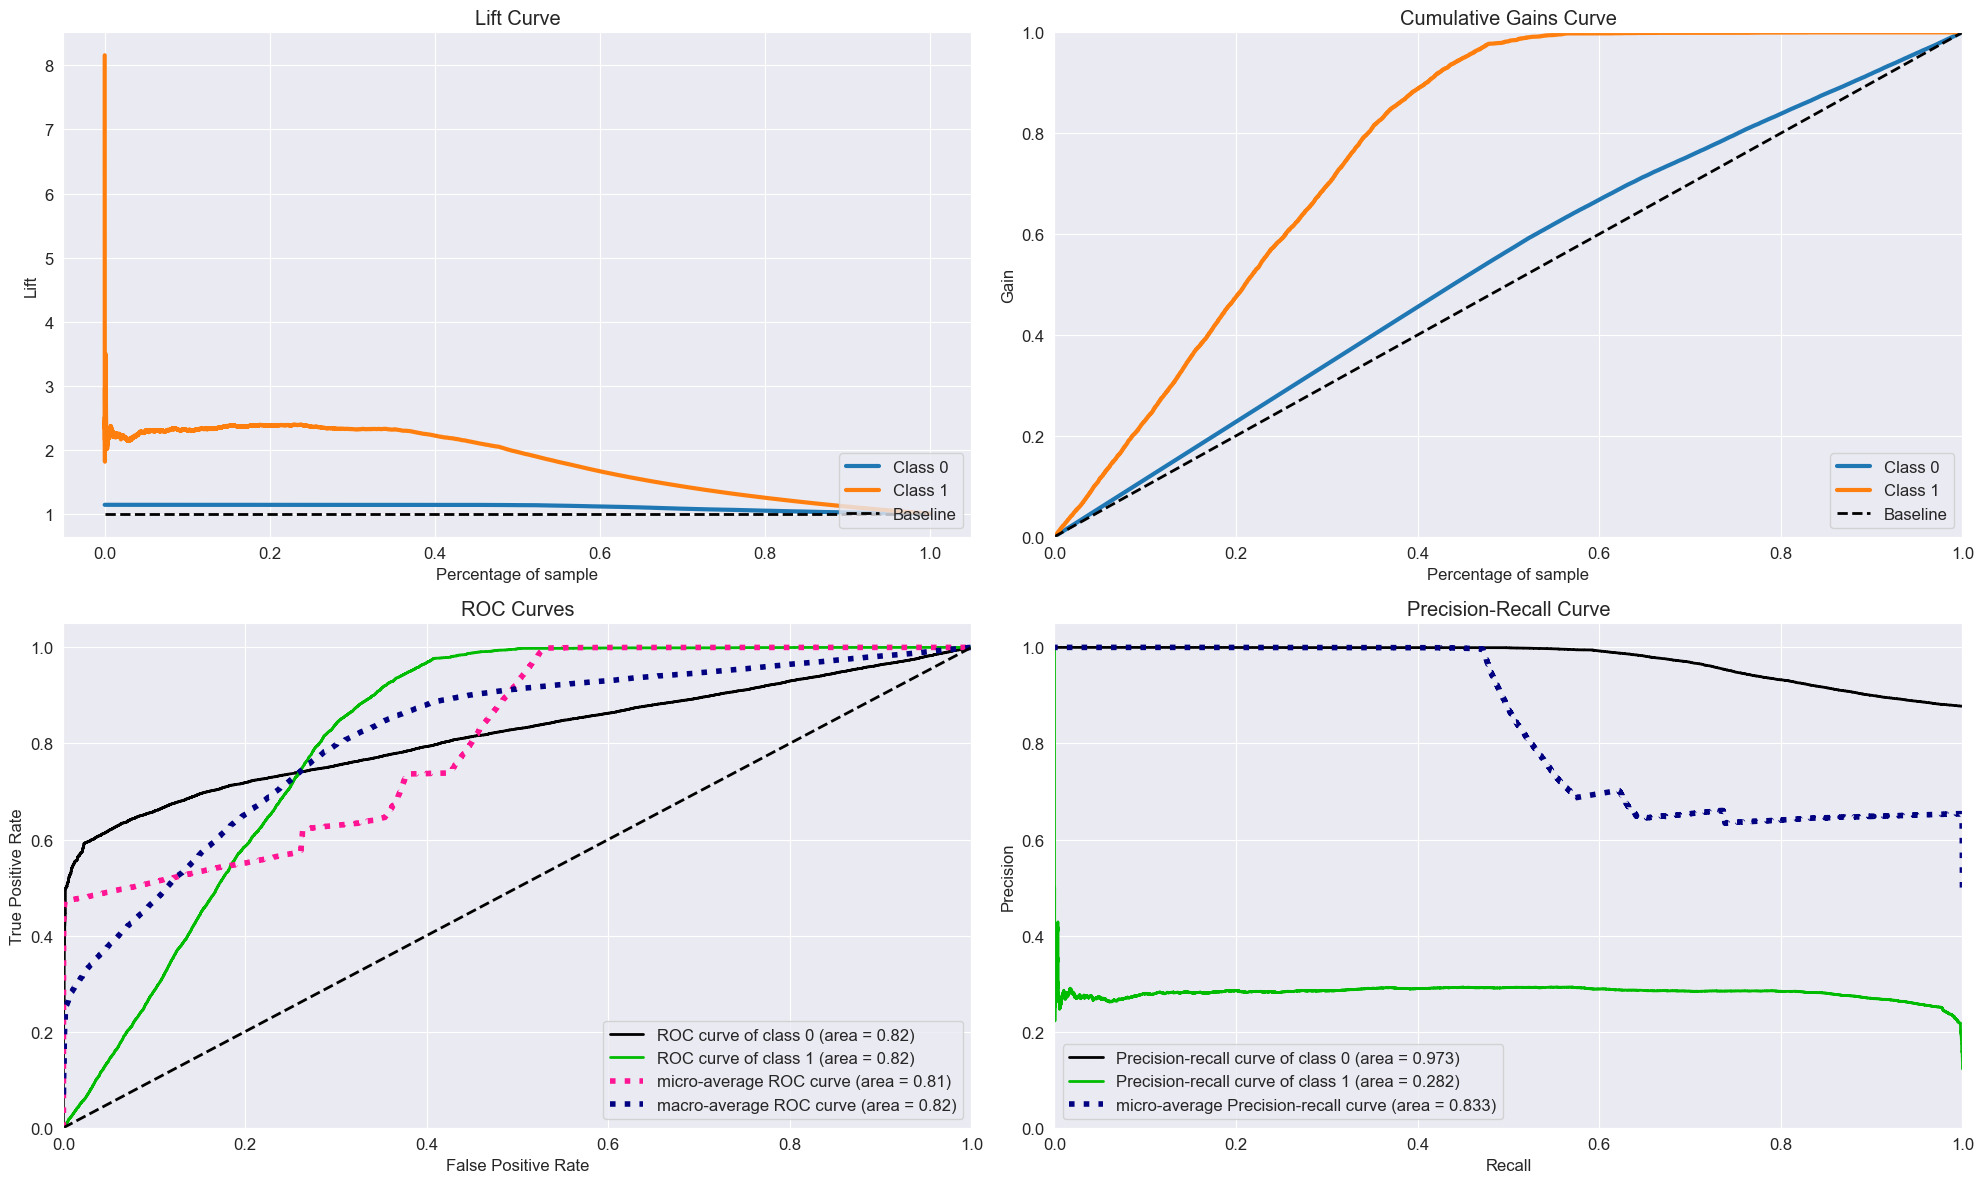

In [30]:
hf.classifier_metrics_plot(y_prob, y_val)

In [31]:
scores = hf.classifier_metrics_test('LogisticRegression', y_val, y_hat, y_prob, 20000)
scores

,balanced_accuracy,f1_score,lift_score,prc_auc,precision,precision_at_20000,recall,recall_at_20000,roc_auc
LogisticRegression,0.78398,0.401054,2.06425,0.281578,0.253017,0.283936,0.966605,0.810475,0.818708


## 7.2 KNeighboors

In [32]:
knn_clf = KNeighborsClassifier(n_neighbors=7, metric='minkowski', p=2, n_jobs=-1)

pipe_knn = Pipeline(steps=[('preprocess', preprocess_scaling), ('KNeighboors', knn_clf)])
pipe_knn.fit(X_under, y_under)

y_hat_knn = pipe_knn.predict(X_val)
y_prob_knn = pipe_knn.predict_proba(X_val)

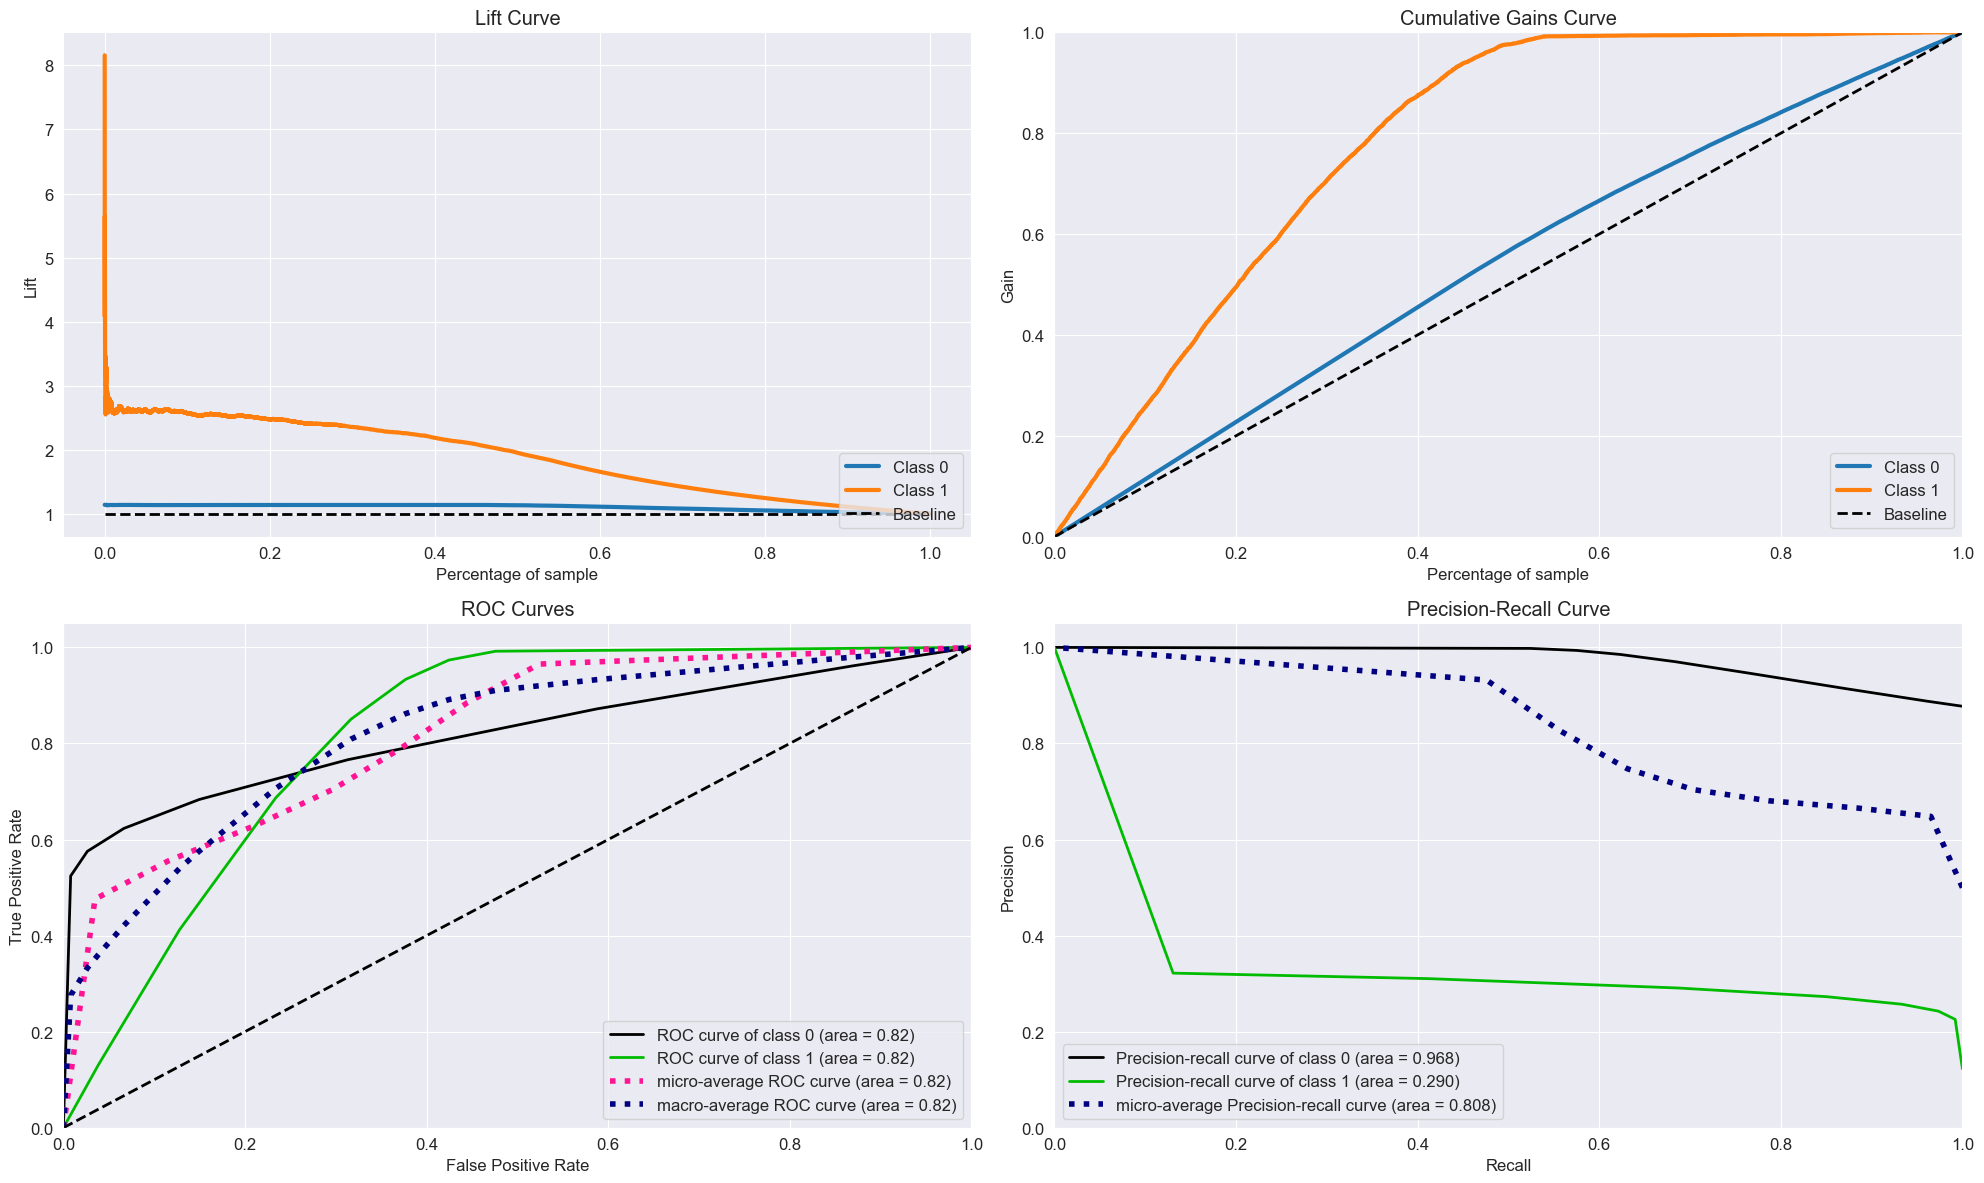

In [33]:
hf.classifier_metrics_plot(y_prob_knn, y_val)

In [34]:
hf.classifier_metrics_test('KNeighboors', y_val, y_hat_knn, y_prob_knn, k=20000)

,balanced_accuracy,f1_score,lift_score,prc_auc,precision,precision_at_20000,recall,recall_at_20000,roc_auc
KNeighboors,0.766884,0.413102,2.22574,0.341783,0.272811,0.278586,0.850435,0.795205,0.820287


## 7.3 LightGBM 

In [35]:
lgbm_clf = LGBMClassifier(random_state=0, class_weight='balanced')

pipe_lgbm = Pipeline(steps=[('preprocess', preprocess_scaling), ('LGBMClassifier', lgbm_clf)])
pipe_lgbm.fit(X_train, y_train)

y_hat_lgbm = pipe_lgbm.predict(X_val)
y_prob_lgbm = pipe_lgbm.predict_proba(X_val)

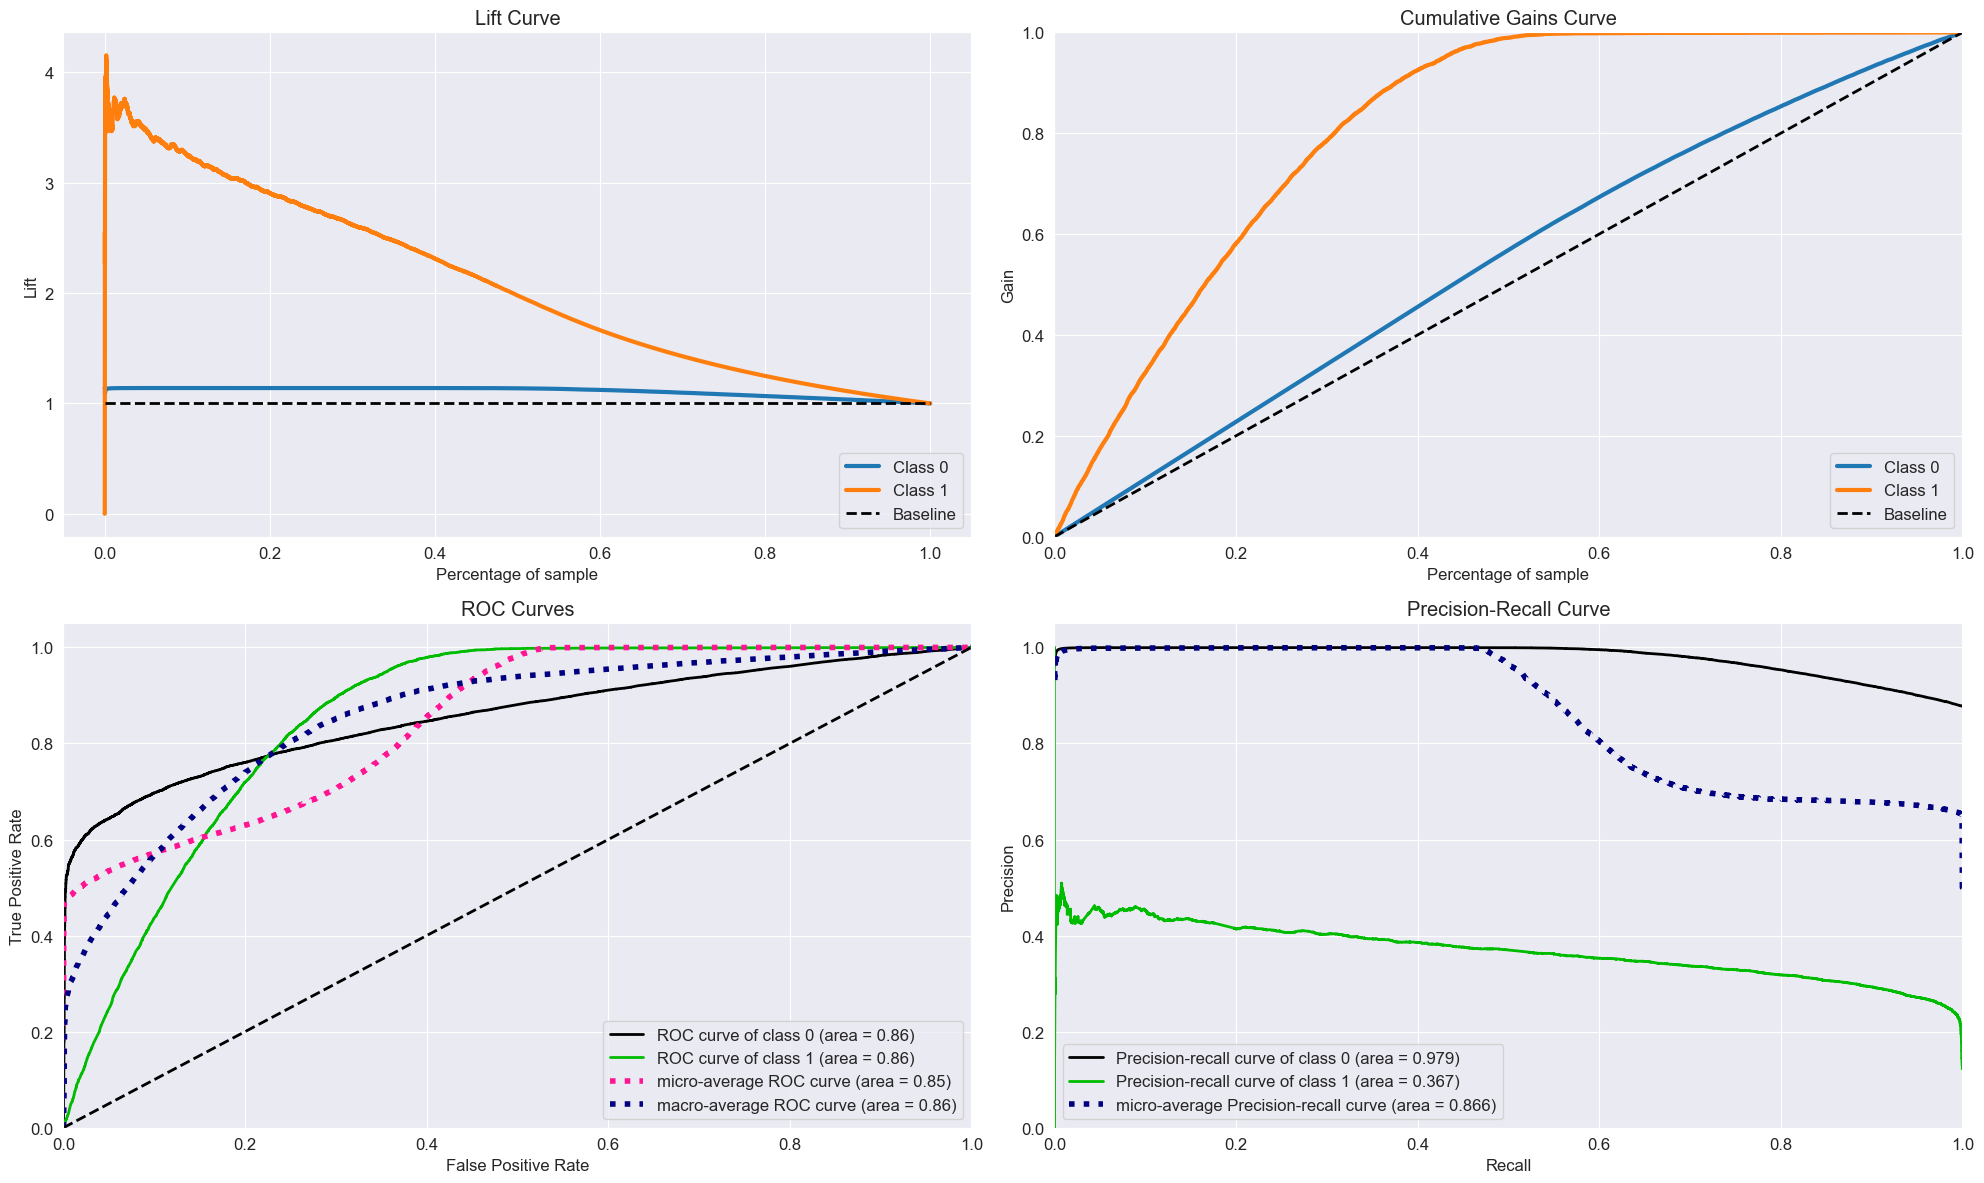

In [36]:
hf.classifier_metrics_plot(y_prob_lgbm, y_val)

In [37]:
hf.classifier_metrics_test('LGBM', y_val, y_hat_lgbm, y_prob_lgbm, k=20000)

,balanced_accuracy,f1_score,lift_score,prc_auc,precision,precision_at_20000,recall,recall_at_20000,roc_auc
LGBM,0.799196,0.433421,2.307858,0.366864,0.282876,0.303485,0.926502,0.866277,0.857256


## 7.4 ExtraTrees

In [38]:
ext_clf = ExtraTreesClassifier(random_state=0)

pipe_ext = Pipeline(steps=[('preprocess', preprocess_scaling), ('ExtraTreesClassifier', ext_clf)])
pipe_ext.fit(X_under, y_under)

y_hat_ext = pipe_ext.predict(X_val)
y_prob_ext = pipe_ext.predict_proba(X_val)

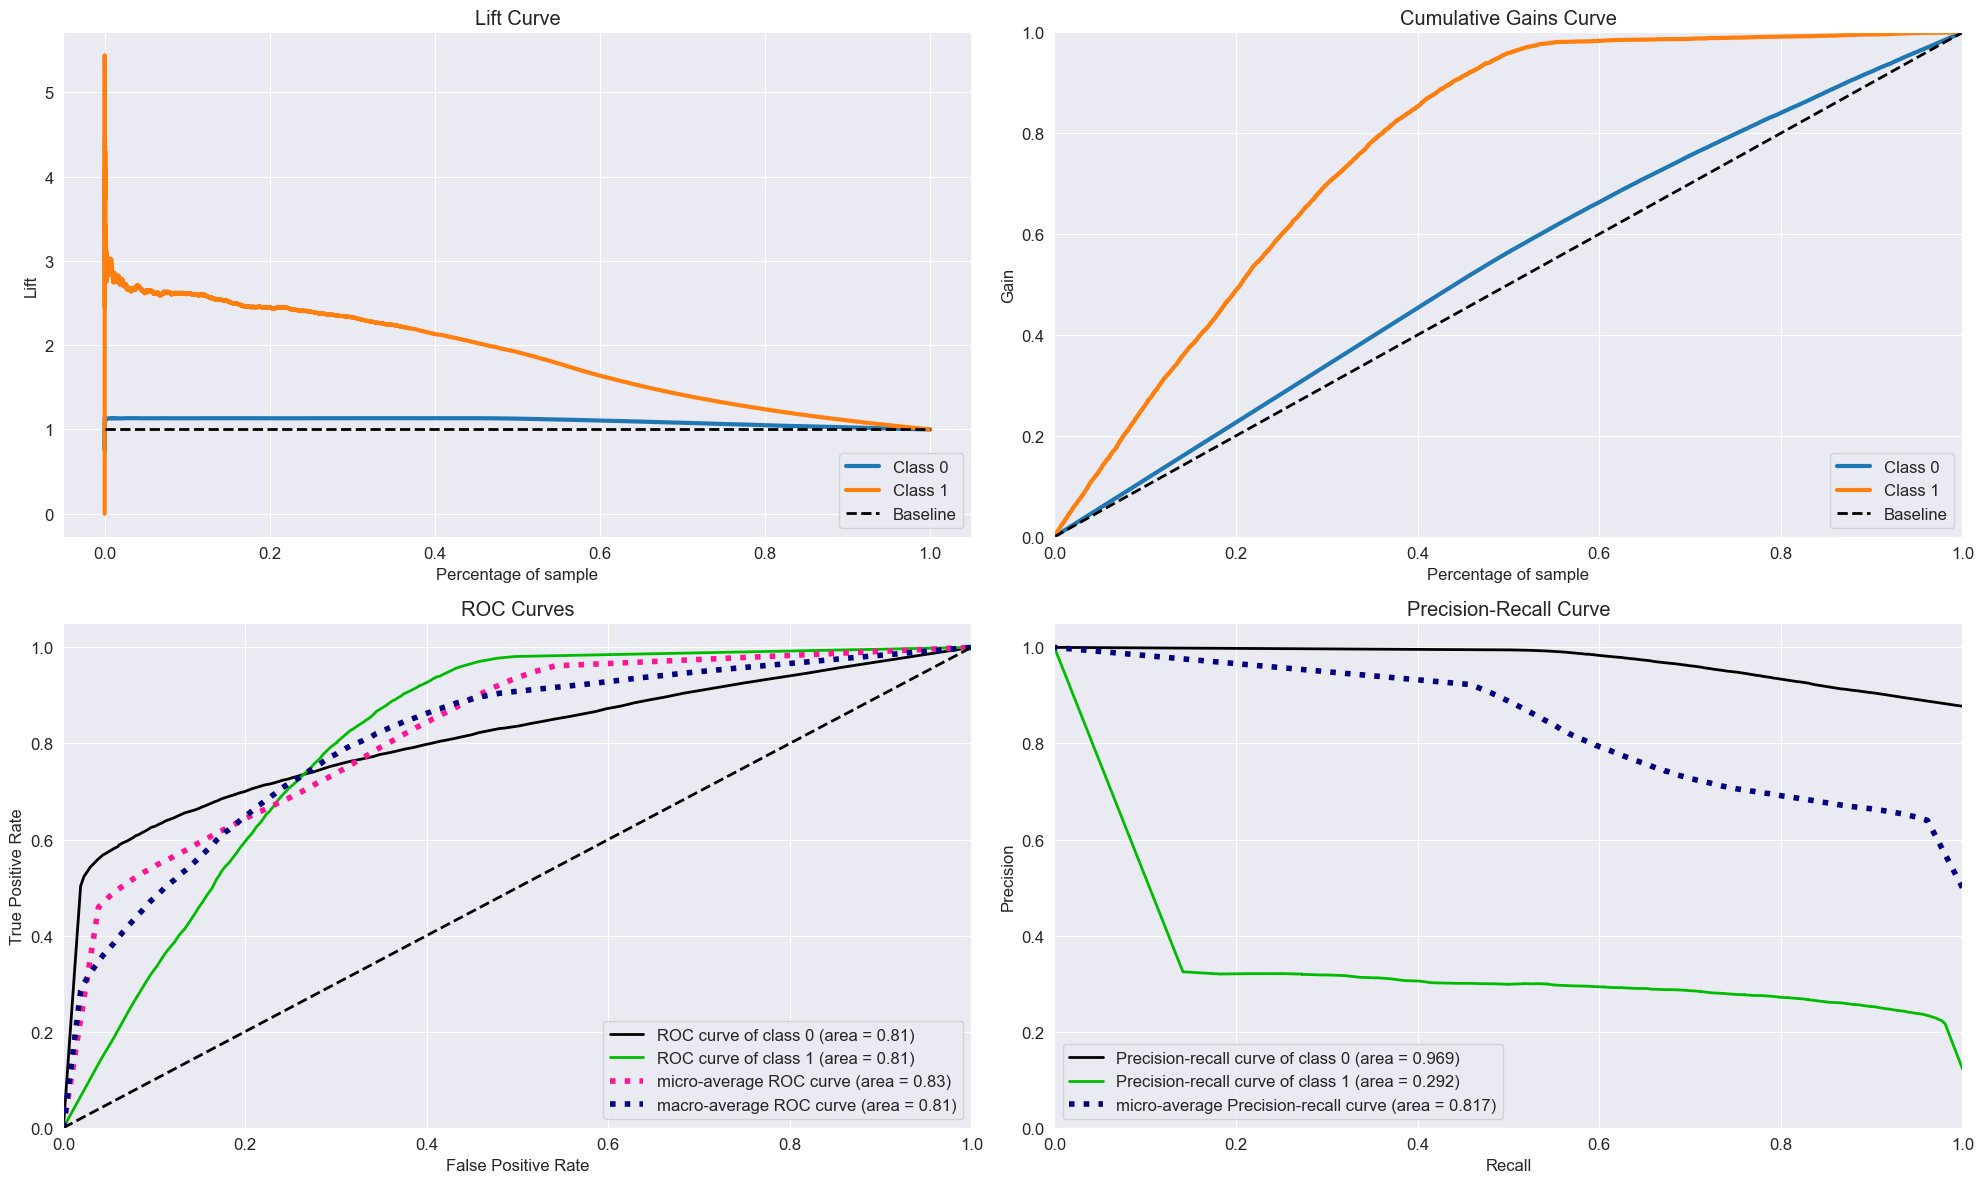

In [39]:
hf.classifier_metrics_plot(y_prob_ext, y_val)


In [40]:
hf.classifier_metrics_test('ExtraTrees', y_val, y_hat_ext, y_prob_ext, k=20000)

,balanced_accuracy,f1_score,lift_score,prc_auc,precision,precision_at_20000,recall,recall_at_20000,roc_auc
ExtraTrees,0.745934,0.406436,2.24349,0.341205,0.274986,0.274536,0.77865,0.783645,0.812092


## 7.5 GaussianNB

In [41]:
gau_clf = GaussianNB()

pipe_gau = Pipeline(steps=[('preprocess', preprocess_scaling), ('GaussianClassifier', gau_clf)])
pipe_gau.fit(X_train, y_train)

y_hat_gau = pipe_gau.predict(X_val)
y_prob_gau = pipe_gau.predict_proba(X_val)

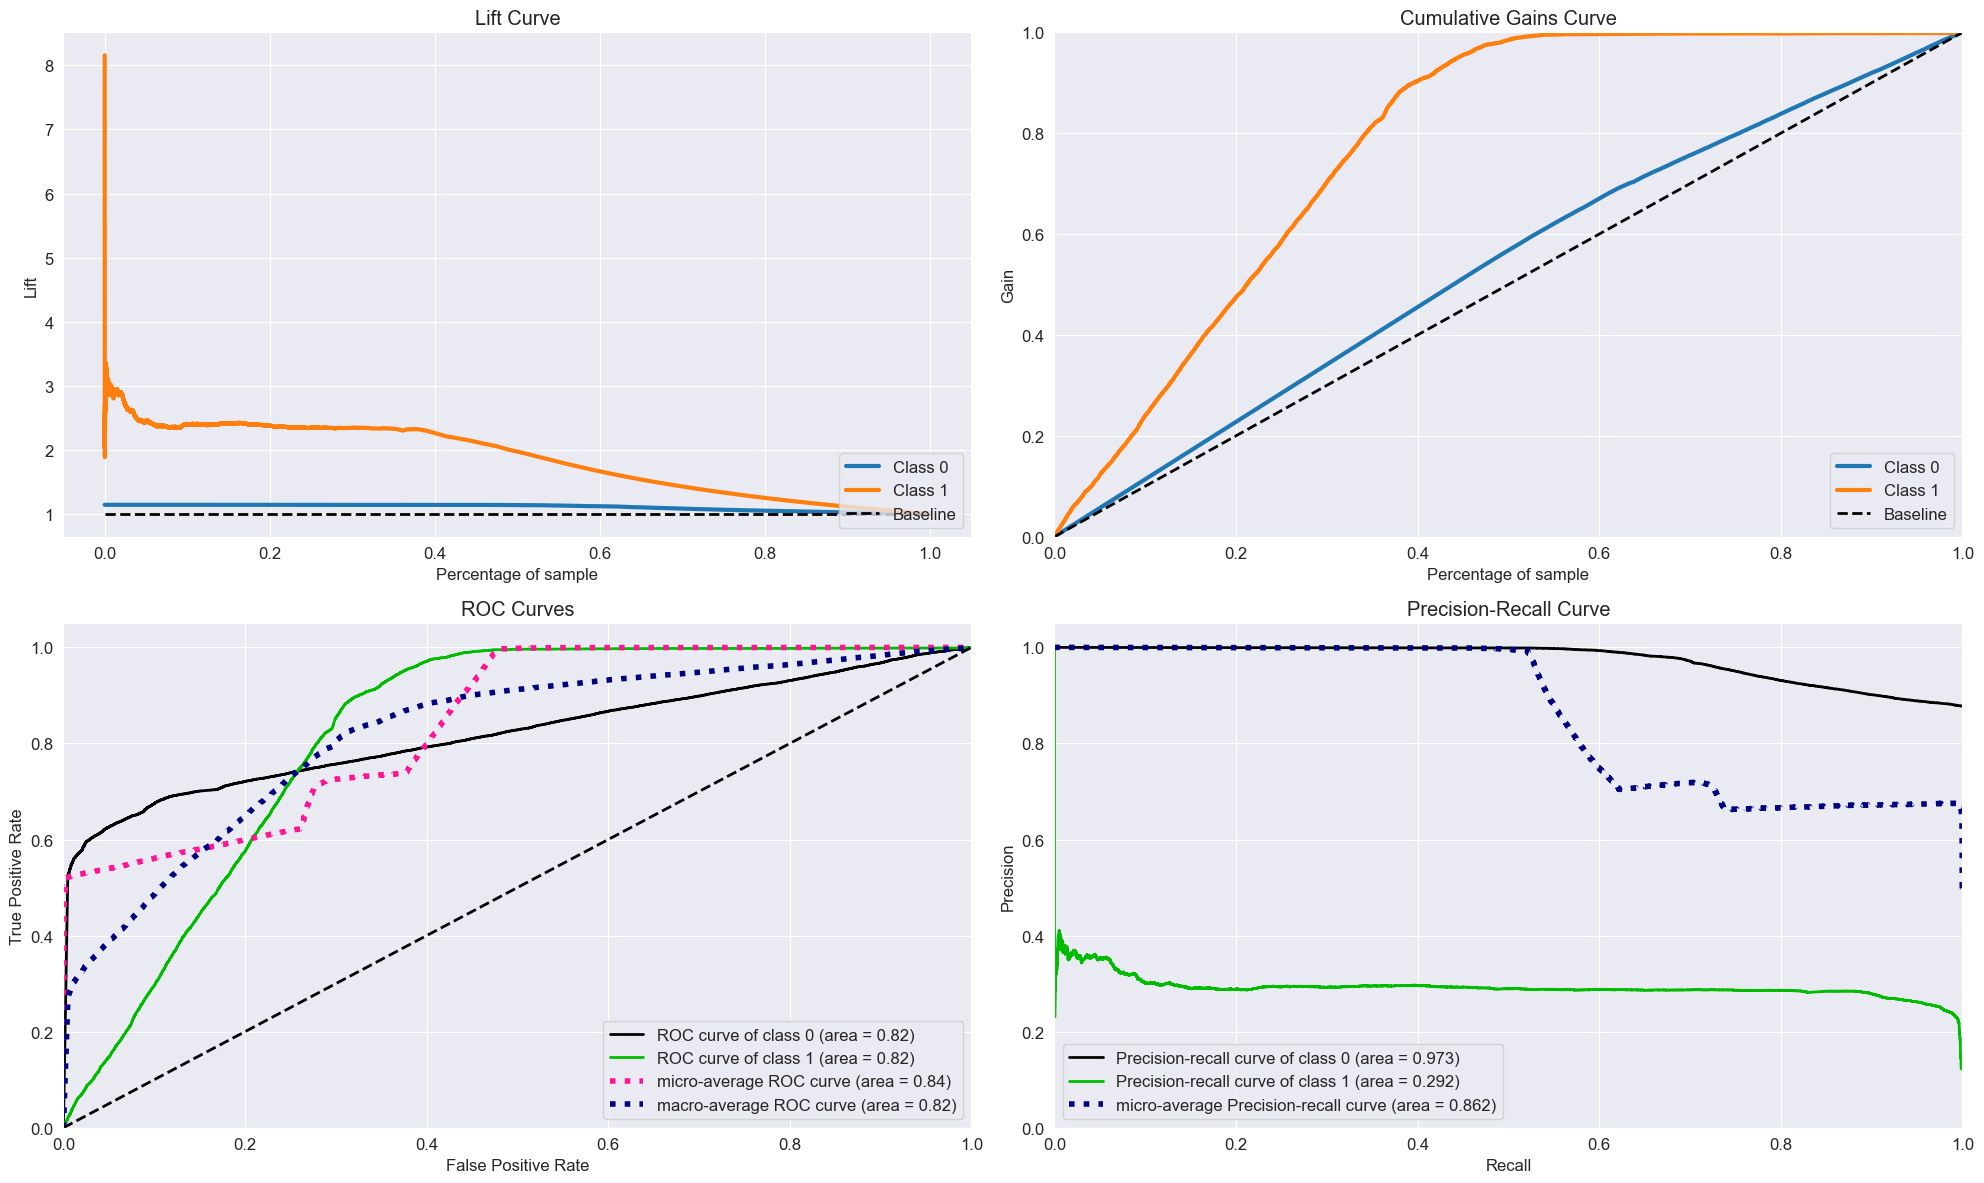

In [42]:
hf.classifier_metrics_plot(y_prob_gau, y_val)

In [43]:
hf.classifier_metrics_test('Gausian', y_val, y_hat_gau, y_prob_gau, k=20000)

,balanced_accuracy,f1_score,lift_score,prc_auc,precision,precision_at_20000,recall,recall_at_20000,roc_auc
Gausian,0.780157,0.427784,2.31882,0.291778,0.284219,0.285336,0.864421,0.814471,0.820908


**Cross-Validation - Metrics**

## 7.5 Models Comparison with Cross-Validation

In [44]:
lr_clf_cv = LogisticRegressionCV(random_state=0, class_weight='balanced')
pipe_lrcv = Pipeline(steps=[('preprocess', preprocess_scaling), ('LogisticClassifier', lr_clf_cv)])

knn_clf_cv = KNeighborsClassifier(n_neighbors=7, metric='minkowski', p=2, n_jobs=-1)
pipe_knncv = imbpipeline(steps=[('resample', undersampling), ('preprocess', preprocess_scaling), ('KNN', knn_clf_cv)])


lgbm_clf_cv = LGBMClassifier(random_state=0, class_weight='balanced')
pipe_lgbmcv = Pipeline(steps=[('preprocess', preprocess_scaling), ('LGBMClassifier', lgbm_clf_cv)])


ext_clf_cv = ExtraTreesClassifier(random_state=0)
pipe_extcv = imbpipeline(steps=[('resample', undersampling), ('preprocess', preprocess_scaling), ('ExtraTrees', ext_clf_cv)])

gau_clf_cv = GaussianNB()
pipe_gaucv = Pipeline(steps=[('preprocess', preprocess_scaling), ('GaussianClassifier', gau_clf_cv)])


models_scores = pd.DataFrame()
models = {
            'LogisticRegression': pipe_lrcv,
            'KNN': pipe_knncv, 
            'LGBM': pipe_lgbmcv,
            'ExtraTrees': pipe_extcv,
            'Gaussian': pipe_gaucv,
        }
for name, model in models.items():

    models_scores = pd.concat([models_scores, hf.cross_val_metrics(name=name, pipeln=model, X=X_train_cv, y=y_train_cv, cv=10, k=20000)])
models_scores

,fit_time,score_time,test_balanced_accuracy,test_f1_score,test_lift_score,test_prc_auc,test_recall,test_precision,test_precision_at_k,test_recall_at_k,test_roc_auc
LogisticRegression,16.3763 +/- 0.7422,0.1118 +/- 0.033,0.7832 +/- 0.0034,0.3998 +/- 0.0032,2.0558 +/- 0.0196,0.285 +/- 0.0092,0.9678 +/- 0.0052,0.252 +/- 0.0024,0.1983 +/- 0.0002,0.9987 +/- 0.0009,0.7832 +/- 0.0034
KNN,0.5082 +/- 0.0218,1.8098 +/- 1.4918,0.7694 +/- 0.0048,0.4153 +/- 0.0044,2.2385 +/- 0.0261,0.3456 +/- 0.0078,0.8545 +/- 0.0095,0.2744 +/- 0.0032,0.1973 +/- 0.0004,0.9937 +/- 0.0022,0.7694 +/- 0.0048
LGBM,0.8204 +/- 0.024,0.1452 +/- 0.008,0.7991 +/- 0.0042,0.4325 +/- 0.0042,2.3005 +/- 0.0262,0.3681 +/- 0.0069,0.9283 +/- 0.0074,0.282 +/- 0.0032,0.1983 +/- 0.0001,0.999 +/- 0.0008,0.7991 +/- 0.0042
ExtraTrees,5.2899 +/- 0.2275,1.4512 +/- 0.0528,0.7439 +/- 0.003,0.405 +/- 0.0031,2.2376 +/- 0.021,0.3401 +/- 0.0093,0.7737 +/- 0.0065,0.2742 +/- 0.0026,0.195 +/- 0.0005,0.9821 +/- 0.0023,0.7439 +/- 0.003
Gaussian,0.3446 +/- 0.0149,0.108 +/- 0.0101,0.777 +/- 0.005,0.4255 +/- 0.005,2.3082 +/- 0.0309,0.2899 +/- 0.0116,0.8577 +/- 0.0086,0.2829 +/- 0.0038,0.1981 +/- 0.0002,0.9979 +/- 0.0009,0.777 +/- 0.005


Overall, LightGBM had the best performance.

Model|precision_at_k|recall_at_k|lift_score
-----|--------------|-----------|----------
LogisticRegression|0.1983 +/- 0.0002|0.9987 +/- 0.0009|2.0558 +/- 0.0196
KNN|0.1973 +/- 0.0004	|0.9937 +/- 0.0022| 2.2385 +/- 0.0261
LGBM|0.1983 +/- 0.0001|	0.999 +/- 0.0008|2.3005 +/- 0.0262
ExtraTrees|0.195 +/- 0.0005|	0.9821 +/- 0.0023|2.2376 +/- 0.021
Gaussian|0.1981 +/- 0.0002|	0.9979 +/- 0.0009|2.3082 +/- 0.0309

# 8.0 Fine Tunning - LGBM

In [45]:
# Objective function to be optimized by optuna
#def objective(trial, x, y):
#
#    param = {
#                'objective': 'binary',
#                'class_weight': 'balanced',
#                'verbosity': -1,
#                'boosting_type': 'gbdt',
#                'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 100, log=True),
#                'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 100, log=True),
#                'num_leaves': trial.suggest_int('num_leaves', 7, 4095),
#                'max_depth': trial.suggest_int('max_depth', 3, 12),
#                'min_child_samples': trial.suggest_int('min_child_samples', 200, 10000, step=100),
#                'n_estimators': trial.suggest_int('n_estimators', 1000, 10000, step=500),
#                'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.3, log=True),
#                'min_split_gain': trial.suggest_float('min_split_gain', 0, 20),
#                'subsample': trial.suggest_float('subsample', 0.2, 0.95, step=0.1),
#                'subsample_freq': trial.suggest_categorical('subsample_freq', [5]),
#                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 0.95, step=0.1),
#                
#            }
#
#    lgbm_t = LGBMClassifier(**param, random_state=0)
#    pipe_lgbm_t = Pipeline([('preprocess', preprocess_scaling), ('lgbm_classifier', lgbm_t)])
#
#    scores = cross_val_score(pipe_lgbm_t, x, y, cv=10, scoring=met.make_scorer(hf.precision_at_k, k=20000))
#    score = scores.mean()
#    
#    return score

In [46]:
#sampler = TPESampler(seed=0)
#study = optuna.create_study(direction='maximize', sampler=sampler)
#study.optimize(lambda trial: objective(trial, X_train_cv, y_train_cv), n_trials=100)


In [ ]:
#print(f'Number of finished trials: {len(study.trials)}')
#print('Best trial')
#trial = study.best_trial
#
#print(f'Value {trial.value}')
#
#print('Parameters:')
#for key, value in trial.params.items():
#    print(f'{key}: {value}')

Number of finished trials: 100
Best trial
Value 0.19515024248787563
Parameters:
reg_alpha: 0.4606696375512969
reg_lambda: 38.204968131192786
num_leaves: 1221
max_depth: 12
min_child_samples: 9500
n_estimators: 10000
learning_rate: 0.000146247922604924
min_split_gain: 13.85590099020865
subsample: 0.2
subsample_freq: 5
colsample_bytree: 0.8


# 9.0. Final Model Performance

## 9.1. Metrics

In [28]:
params = {
            'reg_alpha': 0.4606696375512969,
            'reg_lambda': 38.204968131192786,
            'num_leaves': 1221,
            'max_depth': 12,
            'min_child_samples': 9500,
            'n_estimators': 10000,
            'learning_rate': 0.000146247922604924,
            'min_split_gain': 13.85590099020865,
            'subsample': 0.2,
            'subsample_freq': 5,
            'colsample_bytree': 0.8
        }

pipe_lgbm_tuned = Pipeline(steps=[('preprocess', preprocess_scaling),('LGBMClassiifer', LGBMClassifier(**params, class_weight='balanced', random_state=0))])

pipe_lgbm_tuned.fit(X_train_cv, y_train_cv)

y_hat_tuned = pipe_lgbm_tuned.predict(X_test)
y_prob_tuned = pipe_lgbm_tuned.predict_proba(X_test)

hf.classifier_metrics_test('LGBM', np.array(y_test), y_hat_tuned, y_prob_tuned, k=20000)

,balanced_accuracy,f1_score,lift_score,prc_auc,precision,precision_at_20000,recall,recall_at_20000,roc_auc
LGBM,0.786224,0.400385,2.052952,0.315115,0.251632,0.286636,0.979306,0.818182,0.833669


Model|precision_at_20000|recall_at_20000|lift_score
-----|------------------|---------------|----------
LGBM Tuned|0.286636|0.818182|2.052952

In [ ]:
#pickle.dump(pipe_lgbm_tuned, open('../models/lgbm_tuned_pipe.pkl', 'wb'))

## 9.1. Cumulative Gain Curve

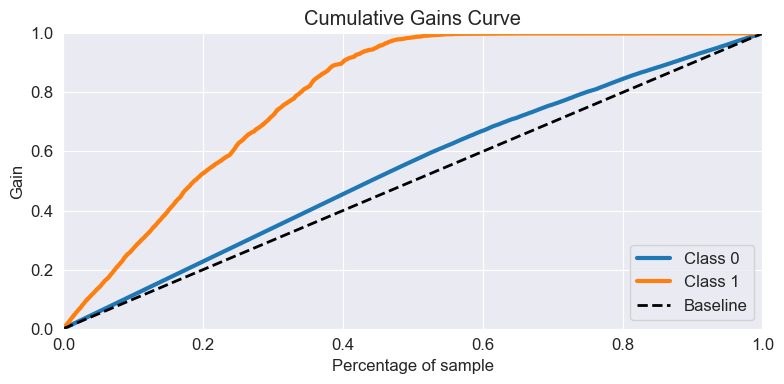

In [30]:
skplt.metrics.plot_cumulative_gain(y_test, y_prob_tuned, figsize=(8, 4));

The curve above tells us that if we are able contact 40% of the population (sorted by the propensity score), we can reach 90% of the customers that are interested in vehicle insurance.

## 9.2. Lift Curve

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

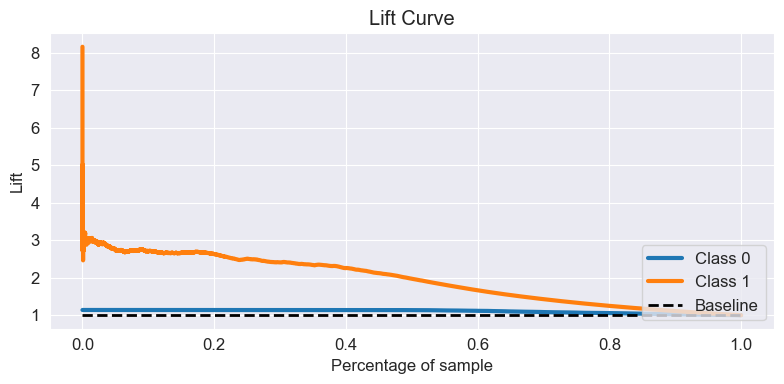

In [31]:
skplt.metrics.plot_lift_curve(y_test, y_prob_tuned, figsize=(8, 4))

In the curve above, for 20% of our sorted data, we have a lift of almost 3. This means that: if we contact the top 20% of customers, we can expect to reach three times more interested customers than we would by contacting the same number of customers randomly.

# 10.0. Business Performance

## 10.1. CEO Questions

### 2. What is the percentage of clients interested in vehicle insurance that the sales team will be able to contact by making 20,000 calls?

In [32]:
pop_percent, target_reached = hf.percentage_of_interested_customers(X_test.shape[0], n_calls=20000, n_customers=127037, y_true=y_test, y_prob=y_prob_tuned)
print(f'{pop_percent:.2%} of the population: {target_reached:.2%} of the targets reached.')

15.74% of the population: 41.97% of the targets reached.


With 20,000 calls, we can contact 15.75% of the 127,037 customers who did not participate in the survey. If we can contact 15.75% of the new customers, we expect to reach 42% of the customers interested in vehicle insurance.

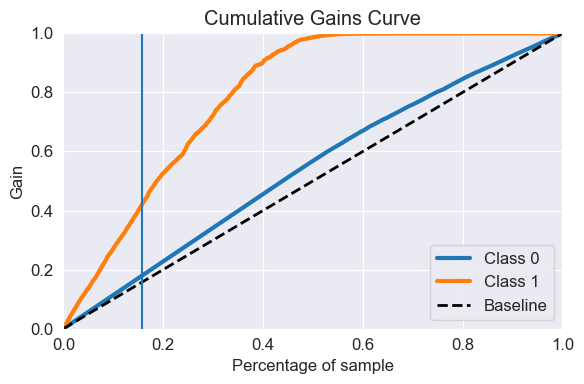

In [33]:
skplt.metrics.plot_cumulative_gain(y_test, y_prob_tuned, figsize=(6, 4))
plt.axvline(0.1575);

**Revenue**

In the test set, we have 12.26% of interested customers. Assuming the same proportion for the new clients, we have 15,575 customers interested in vehicle insurance. With 20,000 calls, we can reach 6541 (42%) of them.

In [34]:
def business_eval(scenario, n_customers, perc_of_interested_customers, target_percentage, n_calls, revenue_per_customer):

    """
    This function calculates the business performance 
    """

    reached_targets = int(n_customers*perc_of_interested_customers*target_percentage)

    total_revenue = reached_targets*revenue_per_customer


    return pd.DataFrame({'Scenario': scenario,'Number Calls': f'{n_calls:,}', 'Targets Reached': f'{reached_targets:,}', 'Annual Premium': f'$ {revenue_per_customer:,.2f}', 'Total Revenue': f'$ {total_revenue:,.2f}'}, index=[0])


In [35]:
# Business Performance before the model (random)
business_perf_random  = hf.business_eval('Random', 127037, 0.1226, 0.1575, 20000, 4500)

# Business Performance using the model n_calls = 20000
business_perf_model = hf.business_eval('Model', 127037, 0.1226, 0.4197, 20000, 4500)

comparison = pd.concat([business_perf_random, business_perf_model], axis=0)
comparison

,Scenario,Number Calls,Targets Reached,Revenue per Customer,Total Revenue
0,Random,"20,000","2,453","4,500.00","$ 11,038,500.00"
0,Model,"20,000","6,536","4,500.00","$ 29,412,000.00"


The model is 2.66 times better than randomly targeting the customers. We expect 2.66 times more revenue using the model.

### 3. If the sales team could make 40,000 calls, what percentage of interested customers would they be able to contact?



In [36]:
pop_percent, target_reached = hf.percentage_of_interested_customers(X_test.shape[0], n_calls=40000, n_customers=127037, y_true=y_test, y_prob=y_prob_tuned)
print(f'{pop_percent:.2%} of the population: {target_reached:.2%} of the targets reached.')

31.49% of the population: 75.72% of the targets reached.


With 40,000 calls, we can contact 31.50% of the 127,037 customers who did not participate in the survey. If we can contact 30.50% of the new customers, we expect to reach 75.70% of the customers interested in vehicle insurance.

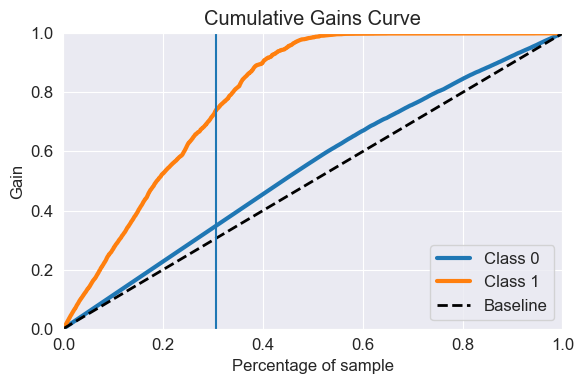

In [37]:
skplt.metrics.plot_cumulative_gain(y_test, y_prob_tuned, figsize=(6, 4))
plt.axvline(0.3050);

**Revenue**

In the test set, we have 12.26% of interested customers. Assuming the same proportion for the new clients, we have 15,575 customers interested in vehicle insurance. With 40,000 calls, we can reach 11,790 (75.70%) of them.

In [38]:
business_perf_random  = business_eval('Random', 127037, 0.1226, 0.3150, 40000, 4500)

business_perf_model = business_eval('Model', 127037, 0.1226, 0.7570, 40000, 4500)

comparison = pd.concat([business_perf_random, business_perf_model], axis=0)
comparison

,Scenario,Number Calls,Targets Reached,Annual Premium,Total Revenue
0,Random,"40,000","4,906","$ 4,500.00","$ 22,077,000.00"
0,Model,"40,000","11,790","$ 4,500.00","$ 53,055,000.00"


The model is 2.40 times better than randomly targeting the customers. We expect 2.40 times more revenue using the model.

### 4. How many calls does the sales team need to make to contact 80% of the customers interested in acquiring vehicle insurance?

In [39]:
base = skplt.metrics.cumulative_gain_curve(y_test, y_prob_tuned[:, 1])[0]
gain = skplt.metrics.cumulative_gain_curve(y_test, y_prob_tuned[:, 1])[1]
index_80 = np.where(gain >= 0.80)[0][0]

n_calls = int(np.ceil(base[index_80]*127037))

print(f'The sales team need to make {n_calls:,} calls to reach 80% of the customers interested in acquiring vehicle insurance.')

The sales team need to make 43,107 calls to reach 80% of the customers interested in acquiring vehicle insurance.


In [40]:
base[index_80]

0.3393216366085329

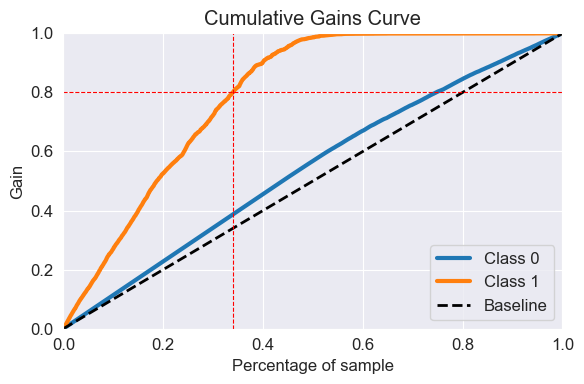

In [72]:
skplt.metrics.plot_cumulative_gain(y_test, y_prob_tuned, figsize=(6, 4))
plt.axhline(0.80, color='r', linestyle='--', linewidth=0.8);
plt.axvline(base[index_80], color='r', linestyle='--', linewidth=0.8)

## 11.0. Model to production

In this section, we retrain the model using the whole data (train, validation, and test set).

In [56]:
data_full = pd.concat([train_data, test], axis=0).reset_index(drop=True)

# Applying the same transformations to the  tes set.
data_full['vehicle_age'] = data_full['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x== '1-2 Year' else 'under_1_year')

data_full['vehicle_damage'] = data_full['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

In [57]:
X_full = data_full.drop(['id', 'response'], axis=1)
y_full = data_full['response']

In [72]:
pipe_lgbm_production = Pipeline(steps=[('preprocess', preprocess_scaling), ('LGBMClassifier_p', LGBMClassifier(**params, class_weight='balanced', random_state=0))])

pipe_lgbm_production.fit(X_full, y_full)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('onehot',
                                                  Pipeline(steps=[('onehot_enc',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  ['gender', 'vehicle_damage',
                                                   'vehicle_age']),
                                                 ('robust_scaler',
                                                  Pipeline(steps=[('robust_sc',
                                                                   RobustScaler())]),
                                                  ['annual_premium']),
                                                 ('minmax',
                                                  Pipeline(steps=[('minmax_sc',
                                                                   MinMaxScaler())]),
                                                  ['age']),
                                                 ('freq_enconder',
                                                  Pip...
                                                   'driving_license'])])),
                ('LGBMClassifier_p',
                 LGBMClassifier(class_weight='balanced', colsample_bytree=0.8,
                                learning_rate=0.000146247922604924,
                                max_depth=12, min_child_samples=9500,
                                min_split_gain=13.85590099020865,
                                n_estimators=10000, num_leaves=1221,
                                random_state=0, reg_alpha=0.4606696375512969,
                                reg_lambda=38.204968131192786, subsample=0.2,
                                subsample_freq=5))])

In [74]:
#pickle.dump(pipe_lgbm_production, open('../models/lgbm_production_pipe.pkl', 'wb'))

## References

https://neptune.ai/blog/evaluation-metrics-binary-classification

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4349800/


https://www.hourly.io/post/cross-selling-insurance

https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

## Test API

In [1]:
import requests

In [4]:
data = pd.read_csv('../data/test_eval.csv').iloc[:5000]
json = data.drop('response', axis=1).to_dict(orient='records')
#data = pd.read_csv('../data/production.csv')

#json = data.to_dict(orient='records')

In [6]:
#url = 'http://127.0.0.1:5000/predictions'
url = 'https://test-api-8b0r.onrender.com/predictions'

header = {'Content-Type': 'application/json'}
js = requests.post(url, json=json, headers=header)

In [7]:
js.status_code

200

In [114]:
pd.concat([test, pd.Series(y_prob_tuned[:, 1])], axis=1)[['id', 'age','region_code', 0]].sample(50, random_state=0)

,id,age,region_code,0
38445,125260,24,23.0,0.130464
30702,86111,78,35.0,0.620229
17937,250016,29,10.0,0.127582
13821,129088,57,28.0,0.644629
54056,101465,22,13.0,0.126048
42115,12598,70,33.0,0.620525
35518,199349,42,28.0,0.703332
22633,354883,21,8.0,0.582729
49140,240110,30,28.0,0.659492
11660,286764,21,8.0,0.126048
